# Trucks only problem #

Install necessary packages

In [3]:
from gurobipy import Model,GRB,LinExpr,quicksum
import numpy as np
from scipy.spatial import distance
import os
import socket
from load_dataset import Dataset

For Ugo's laptop

In [4]:

# Define the node name or another identifier of your laptop
my_laptop_node = 'Ugos-MacBook-Pro.local'

# Get the current system's node name using socket.gethostname()
current_node = socket.gethostname()

if current_node == my_laptop_node:
    # Set the environment variable for Gurobi license file
    os.environ["GRB_LICENSE_FILE"] = "/Users/ugomunzi/gurobi/licenses/gurobi.lic"
    print("Gurobi license path set for Ugo's MacBook Pro.")
else:
    print("Not Ugo's MacBook Pro, using default or no specific license settings.")


Not Ugo's MacBook Pro, using default or no specific license settings.


Define model parametres

In [5]:
## MODEL PARAMETERS ##
W_T = 1500 #empty weight truck [kg]
Q_T = 1000 #load capacity of trucks [kg]
#W_D = 25 #empty weight drone [kg]
#Q_D = 5 #load capacity of drones [kg]
C_T = 25 #travel cost of trucks per unit distance [monetary unit/km]
#C_D = 1 #travel cost of drones per unit distance [monetary unit/km]
C_B = 500 #basis cost of using a truck equipped with a drone [monetary unit]
#E = 0.5 #maximum endurance of empty drones [hours]
S_T = 60 #average travel speed of the trucks [km/h]
#S_D = 65 #average travel speed of the drones [km/h]

Define Big M constant

In [6]:
M = 1e9 #big M constant for big M method(1e9 is largest order of magnitude before numerical issues arise in Gurobi)

Load Dataset using load_dataset.py

In [7]:
## LOAD DATASET ##
current_dir = os.getcwd()
# Select which data folder to use
data_subfolder = '0.3'
data_subfoldercopy = '0.3_copy'
data_num_nodes = '40'
data_area = '40'

data_file_name = f'{data_num_nodes}_{data_area}_{data_subfoldercopy}'
dataset_path = f'dataset/{data_subfolder}/{data_file_name}.txt'
output_solution_file_path = os.path.join(current_dir, data_file_name + '_solution.sol')#used to save solution file
output_model_file_path = os.path.join(current_dir, data_file_name + '_model.lp')#used to save model file
dataset = Dataset(dataset_path)



Pre-processing

In [8]:
## FUNCTIONS ##
def get_manhattan_distance(data):
    """
    Returns a dictionary with manhattan distances between all nodes in dataset
    """
    distance_dict = {}
    for node1 in data.keys():
        for node2 in data.keys():
            distance_dict[node1, node2] = distance.cityblock([data[node1]['X'], data[node1]['Y']], [data[node2]['X'], data[node2]['Y']])
    return distance_dict

def get_time_dict(data, S_T, distance_dict):
    """
    Returns a dictionary with travel times between all nodes in dataset
    """
    time_dict = {}
    for node1 in data.keys():
        for node2 in data.keys():
            time_dict[node1, node2] = distance_dict[node1, node2] / S_T
    return time_dict

def check_in_x_var(i, j):
    """Check if the route from node i to node j is valid instead of having to pass bunch of conditions in each constraint.
    Conditions:
        1- cant travel between same node (i != j)
        2- cant leave return depot D1 (i != 'D1')
        3- cant arrive at start depot D0 (j != 'D0')
        4- cant travel from D0 to D1 (not (i == 'D0' and j == 'D1'))
            note that constraints 2 & 3 already ensure you cant travel from D1 to D0
    """
    if i != j and i != 'D1' and j != 'D0' and not (i == 'D0' and j == 'D1'):
        return True
    return False

def get_cost_obj(C_T, truck_distance_dict, active_routes_truck, cost_weight=1):
    """
    Returns the cost objective value for the model after it has optimised
    """
    cost_obj = 0
    for truck in active_routes_truck.keys():
        for route in active_routes_truck[truck]:
            i, j, _, _ = route
            cost_obj += cost_weight * C_T * truck_distance_dict[i, j]
    return cost_obj

def get_environmental_obj(W_T, truck_distance_dict, active_routes_truck, environmental_weight=1):
    """
    Returns the environmental objective value for the model after it has optimised
    """
    environmental_obj = 0
    for truck in active_routes_truck.keys():
        for route in active_routes_truck[truck]:
            i, j, _, _ = route
            environmental_obj += environmental_weight * W_T * truck_distance_dict[i, j]
    return environmental_obj

def get_time_obj(active_routes_truck, time_weight=1):
    """
    Returns the time objective value for the model after it has optimised
    """
    time_obj = 0
    for truck in active_routes_truck.keys():
        for route in active_routes_truck[truck]:
            _, _, timestamp, _ = route
            time_obj = max(time_obj, timestamp)
    return time_weight * time_obj


num_trucks = 5 # reduce from 10 to five to speed up optimisisation (basically half the number of variables)
truck_distance_dict = get_manhattan_distance(dataset.data)
truck_time_dict = get_time_dict(dataset.data, S_T, truck_distance_dict)

#definitions of N_0, N and N_plus follow from paper
N = list(dataset.data.keys()) #set of nodes with depot at start (D0) and at end (D1)
N_customers = N.copy()
N_customers.remove('D0')
N_customers.remove('D1')
Tr = [f'Tr{i}' for i in range(1, num_trucks+1)] #set of trucks

Define the model

In [9]:
# Create a new model
model = Model("Truck_Routing")

# Define decision variables
x = model.addVars(Tr, [(i, j) for i in N for j in N if check_in_x_var(i, j)], lb=0, ub=1, vtype=GRB.BINARY, name='x')
y = model.addVars(Tr, lb=0, ub=1, vtype=GRB.BINARY, name='y')
t = model.addVars(Tr, N, lb=0, vtype=GRB.CONTINUOUS, name='t')
t_max = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name='t_max') #used for the minimising the max delivery time (find max time of all trucks, not each individual truck)
# Define payload variables for each truck and node (used for calculating weight of truck when travelling between nodes)
payload = model.addVars(Tr, [(i, j) for i in N for j in N if check_in_x_var(i, j)], lb=0, ub=Q_T, vtype=GRB.CONTINUOUS, name='payload')#payload present on truck when travelling between i to j, gets updated after each delivery to a customer
# Define dynamic weight variables
W_dynamic = model.addVars(Tr, [(i, j) for i in N for j in N if check_in_x_var(i, j)], lb=0, vtype=GRB.CONTINUOUS, name='W_dynamic')#similar to payload but includes the empty weight of truck aswell

# Objective 1: Cost both due to transportation and base cost of using truck if active)
cost_obj = quicksum(C_T * truck_distance_dict[i,j] * x[truck,i,j] for i in N for j in N if check_in_x_var(i, j) for truck in Tr) + \
           quicksum(C_B * y[truck] for truck in Tr)
# Objective 2: environmental_obj is distance[i,j] * Weight* x[v,i,j] for all v,i,j (i.e. energy consumption)
environmental_obj = quicksum(truck_distance_dict[i,j] * W_dynamic[truck, i, j] * x[truck,i,j] for i in N for j in N if check_in_x_var(i, j) for truck in Tr)
# Objective 3: minimise max delivery time for each truck
time_obj = t_max

#set weights such that all cost objectives are in same order of magnitude (approx 10^3, time is larger to enforce optimiser to use multiple trucks to reduce max delivery time)
#below weights enforce the optimiser to use multiple trucks to reduce max delivery time
cost_weight = 1
environmental_weight = 0.01
time_weight = 10000

"""
cost_weight = 1
environmental_weight = 1 
time_weight = 1
"""
obj = cost_weight * cost_obj + environmental_weight * environmental_obj + time_weight * time_obj
model.setObjective(obj, GRB.MINIMIZE)

model.update()

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2518569
Academic license 2518569 - for non-commercial use only - registered to a.___@student.tudelft.nl


Constraint 1: Each customer is visited by exactly one truck

In [10]:
# Constraint 1: Each customer is visited by exactly one truck

for customer in N_customers:
    # Initialize the sum for the current customer
    sum_for_current_customer = 0

    # Loop over each truck
    for truck in Tr:
        # Loop over each node
        for node in N:
            # Skip if customer is equal to node
            if check_in_x_var(node, customer):
                # Add the variable to the sum
                sum_for_current_customer += x[truck, node, customer]

    # The sum for the current customer must be equal to 1
    model.addConstr(sum_for_current_customer == 1, name=f'Customer_{customer}_visited_once')

Constraint 2: Each truck must leave the depot if active

In [11]:
# Constraint 2: Each truck must leave the depot if active

for truck in Tr:
    sum_for_current_vehicle = quicksum(x[truck, 'D0', customer] for customer in N_customers)
    model.addConstr(sum_for_current_vehicle == y[truck], name=f'Truck_leaves_depot_{truck}')

Constraint 3: Each vehicle arrives at depot if active

In [12]:

# Constraint 3: Each truck must return to the depot if active

for truck in Tr:
    sum_for_current_vehicle = quicksum(x[truck, customer, 'D1'] for customer in N_customers)
    model.addConstr(sum_for_current_vehicle == y[truck], name=f'Truck_returns_to_depot_{truck}')

Constraint 4: If a vehicle arrives at a customer node it must also leave

In [13]:
# Constraint 4: If a truck arrives at a customer node it must also leave (flow balance)

for truck in Tr:
    for node in N_customers:
        model.addConstr(
            quicksum(x[truck, node, j] for j in N if check_in_x_var(node, j)) == 
            quicksum(x[truck, j, node] for j in N if check_in_x_var(j, node)),
            name=f'Flow_balance_{truck}_{node}'
        )

Constraint 5: Time at a node is equal or larger than time at previous nodes plus travel time (or irrelevant). Eliminates need for subtour constraints.

In [14]:
#Constraint 5: Time at a node is equal or larger than time at previous nodes plus travel time (or irrelevant). Eliminates need for subtour constraints.

# Add time constraints for all vehicles, nodes, and customers
for truck in Tr:
    for node in N:
        for customer in N:
            if check_in_x_var(node, customer):
                model.addConstr(
                    t[truck, customer] >= t[truck, node] + truck_time_dict[(node, customer)] - M * (1 - x[truck, node, customer]),
                    name=f'Time_{truck}_{node}_{customer}'
                )

Constraint 6: Payloads

In [15]:
# Constraint 6: The total payload delivered to the customer must be less or equal to the truck load capacity Q_T

for truck in Tr:
    model.addConstr(quicksum(dataset.data[i]['Demand'] * x[truck, i, j] for i in N for j in N if check_in_x_var(i, j)) <= Q_T, 
                    name=f'Payload_{truck}')

Constraint 7 : link y variable to x variable.

In [16]:
# Constraint 7: Link y variable to x variable : TRUCKS
#if any link in x (for each truck) is active -> y = 1
# can do this by checking if each truck leaves the depot (all trucks must leave depot if active)

for truck in Tr:
    model.addConstr(y[truck] == quicksum(x[truck, 'D0', i] for i in N_customers), name=f'Link_y{truck}_to_x_{truck}')

Constraint 8: Set departure time from depot D0 for each truck = 0

In [17]:
# Constraint 8: set departure time from depot D0 for each truck = 0

for truck in Tr:
    model.addConstr(t[truck, 'D0'] == 0, name=f'Departure_time_{truck}_D0')

Constraint 9: update time variables.

In [18]:
# Constraint 9: Update time variable for trucks
# Loop over each truck
for truck in Tr:
    # Loop over each node (destination)
    for j in N:
        if j != 'D0':  # Ensuring no calculation is made for the time to 'D0' as it's the starting point only
            # Initialize the sum for arriving at node j from any node i
            sum_for_arrival_to_j = quicksum((t[truck, i] + truck_time_dict[i, j]) * x[truck, i, j]
                                            for i in N if check_in_x_var(i, j))
            
            # Add the constraint that sets the arrival time at j based on departure times from all nodes i
            model.addConstr(t[truck, j] == sum_for_arrival_to_j, name=f'Update_time_{truck}_{j}')

Constraint 10: update max delivery time variable.

In [19]:
# Constraint 10: Update max delivery time variable
for truck in Tr:
    for node in N:
        # Add a constraint to the model that the maximum delivery time is greater than or equal to the delivery time to the customer for each vehicle
        model.addConstr(t_max >= t[truck, node], name=f'Update_max_delivery_time_{truck}_{node}')

CONSTRAINTS FOR DYNAMIC WEIGHTS AND PAYLOAD

Constraint 11: set payload for each truck at depot = sum of demand of all customers visited by truck

In [20]:
# Constraint 11: set payload for each truck at depot = sum of demand of all customers visited by truck
#note: this works, checked manually
for truck in Tr:
    sum_for_current_truck = 0
    for i in N:
        for j in N:
            if check_in_x_var(i, j):
                sum_for_current_truck += dataset.data[j]['Demand'] * x[truck, i, j]
        if check_in_x_var('D0', i):
            model.addConstr(payload[truck, 'D0', i] == sum_for_current_truck * x[truck, 'D0', i], name=f'Payload_{truck}_D0_{i}')

Constraint 12: each time truck delivers to a customer, the payload is updated

In [21]:
#Constraint 12: each time truck delivers to a customer, the payload is updated
for truck in Tr:
    for i in N:
        for j in N_customers:
            for k in N:
                """
                i is node which was previously visited by truck
                j is customer node where truck is delivering
                k is node where truck is going next
                """
                if check_in_x_var(i, j) and check_in_x_var(j, k):
                    model.addConstr(payload[truck, j, k] <= payload[truck, i, j] - dataset.data[j]['Demand'] * x[truck, i, j] + M * (1 - x[truck, i, j]), name=f'Payload_update_{truck}_{truck}_{i}_{j}_{k}')

Constraint 13: Explicitly set payload to zero for inactive routes (for some reason without this some inactive trucks have payload = 1000)

In [22]:
# Constraint 13: Explicitly set payload to zero for inactive routes (for some reason without this some inactive trucks have payload = 1000)
for truck in Tr:
    for i in N:
        for j in N:
            if check_in_x_var(i, j):
                model.addConstr(payload[truck, i, j] <= M * x[truck, i, j], name=f'Zero_inactive_payload_{truck}_{i}_{j}')

# Constraint 14: update dynamic weight for each truck at each node (W_dynamic[truck, i, j] = W_T + payload[truck, i, j]) only when link (thus truck) is active
for truck in Tr:
    for i in N:
        for j in N:
            if check_in_x_var(i, j):
                model.addConstr(W_dynamic[truck, i, j] == (W_T + payload[truck, i, j]) * x[truck, i, j], name=f'Update_dynamic_weight_{truck}_{i}_{j}')

Constraint 14: update dynamic weight for each truck at each node (W_dynamic[truck, i, j] = W_T + payload[truck, i, j]) only when link (thus truck) is active

In [23]:
# Constraint 14: update dynamic weight for each truck at each node (W_dynamic[truck, i, j] = W_T + payload[truck, i, j]) only when link (thus truck) is active
for truck in Tr:
    for i in N:
        for j in N:
            if check_in_x_var(i, j):
                model.addConstr(W_dynamic[truck, i, j] == (W_T + payload[truck, i, j]) * x[truck, i, j], name=f'Update_dynamic_weight_{truck}_{i}_{j}')

Update, tune and run the model

In [24]:
# Update the model to integrate new variables
model.update()

# Write model to a file
model.write('TruckonlySimple.lp')

# Tune solver parameters
#model.tune()

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print('Optimal objective: %g' % model.objVal)
    for v in model.getVars():
        if v.x > 0:
            print('%s: %g' % (v.varName, v.x))
else:
    print('Optimization was stopped with status %d' % model.status)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2518569 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 10367 rows, 2416 columns and 33040 nonzeros
Model fingerprint: 0x0057656b
Model has 780 quadratic objective terms
Model has 1685 quadratic constraints
Variable types: 1631 continuous, 785 integer (785 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  QMatrix range    [1e+00, 5e+00]
  QLMatrix range   [1e-01, 2e+03]
  Objective range  [2e+02, 1e+04]
  QObjective range [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve added 112 rows and 7 columns
Presolve time: 0.3

Post-processing

Active trucks: ['Tr1', 'Tr2', 'Tr3']
Active routes for trucks: {'Tr1': [('D0', 'C4', 1.2483333333950999, 1507.8), ('C4', 'C12', 1.5433333333955714, 1503.0), ('C12', 'D1', 3.086666666666682, 1500.0)], 'Tr2': [('D0', 'C11', 1.1233333333333333, 1509.2), ('C11', 'C3', 1.2316666682561261, 1507.9), ('C3', 'C5', 1.4250000015895083, 1506.3), ('C5', 'C2', 1.706666638056464, 1504.6), ('C2', 'C1', 2.48499997138977, 1501.7), ('C1', 'D1', 2.85, 1500.0)], 'Tr3': [('D0', 'C10', 0.3133333921432495, 1515.5), ('C10', 'C9', 0.8299999999999979, 1512.4), ('C9', 'C8', 1.3766666666667424, 1507.6), ('C8', 'C7', 1.5133333333334396, 1506.4), ('C7', 'C6', 2.351666666666625, 1504.5), ('C6', 'D1', 2.5600000000000462, 1500.0)]}
Cost objective/Total delivery cost [$]: 12745.0
Environmental objective [kg * km]: 7647.0
Time objective: 30866.66666666682
Max delivery time: 3 hours, 5 minutes, 11 seconds


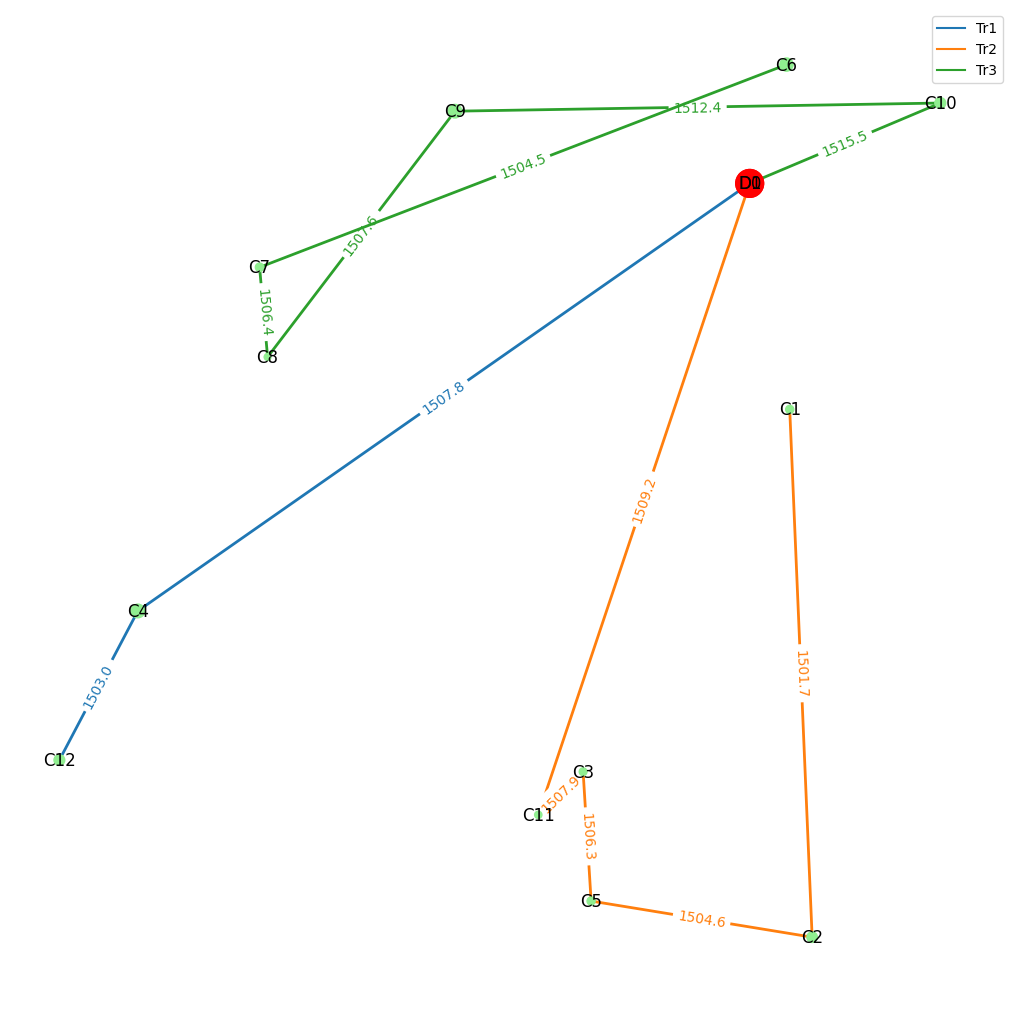

In [25]:
# Extract and store the solution
solution = {var.varName: var.x for var in model.getVars()}

# Extract active trucks
active_trucks = [v for v in Tr if 'T' in v and solution[f'y[{v}]'] >= 0.99]

# Extract routes for active trucks
active_routes_truck = {} #for each truck and pair of nodes (i, j) store (node from, node to, timestamp, weight) of truck when travelling between i and j (ordered by increasing time)
for truck in active_trucks:
    active_routes_truck[truck] = []
    for node_from in N:
        for node_to in N:
            if node_from != node_to and solution.get(f'x[{truck},{node_from},{node_to}]', 0) >= 0.99:
                timestamp = solution.get(f't[{truck},{node_to}]', 0)
                weight = solution.get(f'W_dynamic[{truck},{node_from},{node_to}]', 0)
                active_routes_truck[truck].append((node_from, node_to, timestamp, np.round(weight, 1)))

# Sort the routes for each truck according to the timestamps
for truck in active_trucks:
    active_routes_truck[truck].sort(key=lambda x: x[2])

print('Active trucks:', active_trucks)
print('Active routes for trucks:', active_routes_truck)

# Print each seperate objective value after optimisation
print('Cost objective/Total delivery cost [$]:', get_cost_obj(C_T, truck_distance_dict, active_routes_truck, cost_weight=cost_weight))
print('Environmental objective [kg * km]:', get_environmental_obj(W_T, truck_distance_dict, active_routes_truck, environmental_weight=environmental_weight))
print('Time objective:', get_time_obj(active_routes_truck, time_weight=time_weight))

#convert t_max to hours, minutes, seconds
t_max_hours = model.getVarByName('t_max').x
t_max_minutes, t_max_seconds = divmod(t_max_hours * 3600, 60)
t_max_hours, t_max_minutes = divmod(t_max_minutes, 60)
print('Max delivery time: {} hours, {} minutes, {} seconds'.format(int(t_max_hours), int(t_max_minutes), int(t_max_seconds)))

#use plotting method in dataset class to visualise
dataset.plot_data(show_demand=False, scale_nodes=True, show_labels=True, active_routes=active_routes_truck, show_weights=True)
#save solution to .sol file
model.write(output_solution_file_path)
#save model to .lp file
model.write(output_model_file_path)

In [47]:
import unittest

class TestConstraints(unittest.TestCase):
    def setUp(self):
        self.solution = {var.varName: var.x for var in model.getVars()}

    def test_constraint_1(self):
        # Check Constraint 1: Each customer is visited by exactly one truck
        for customer in N_customers:
            # Calculate the sum of x for the current customer
            sum_for_current_customer = sum(solution[f'x[{truck},{node},{customer}]'] for truck in Tr for node in N if f'x[{truck},{node},{customer}]' in solution)

            # Check if the sum is equal to 1
            assert sum_for_current_customer == 1, f'Constraint 1 violated for customer {customer}'

    def test_constraint_2(self):
        # Check Constraint 2: Each truck must leave the depot if active
        for truck in Tr:
            # Calculate the sum of x for the current truck leaving the depot
            sum_for_current_truck = sum(solution[f'x[{truck},D0,{customer}]'] for customer in N_customers if f'x[{truck},D0,{customer}]' in solution)

            # Check if the sum is equal to y[truck]
            assert sum_for_current_truck == solution[f'y[{truck}]'], f'Constraint 2 violated for truck {truck}'

    def test_constraint_3(self):
        # Test for Constraint 3: Each truck must return to the depot if active
        for truck in Tr:
            sum_return_to_depot = sum(solution[f'x[{truck},{customer},D1]'] for customer in N_customers if f'x[{truck},{customer},D1]' in solution)
            assert sum_return_to_depot == solution[f'y[{truck}]'], f'Constraint 3 violated for truck {truck}'

    def test_constraint_4(self):
        # Test for Constraint 4: Flow balance for each truck at each node
        for truck in Tr:
            for node in N_customers:
                sum_arrivals = sum(solution[f'x[{truck},{node},{j}]'] for j in N if f'x[{truck},{node},{j}]' in solution)
                sum_departures = sum(solution[f'x[{truck},{j},{node}]'] for j in N if f'x[{truck},{j},{node}]' in solution)
                assert sum_arrivals == sum_departures, f'Constraint 4 violated for truck {truck} at node {node}'

    def test_constraint_5(self):
        # Check Constraint 5: Time at a node is equal or larger than time at previous nodes plus travel time (or irrelevant)
        for truck in Tr:
            for node in N:
                for customer in N:
                    if f'x[{truck},{node},{customer}]' in solution and solution[f'x[{truck},{node},{customer}]'] > 0:
                        # Check if the time at the customer is greater or equal to the time at the node plus the travel time
                        assert round(solution[f't[{truck},{customer}]'],2) >= round(self.solution[f't[{truck},{node}]'] + truck_time_dict[(node, customer)], 2), f'Constraint 5 violated for truck {truck}, node {node}, customer {customer}'

    def test_constraint_6(self):
        for truck in Tr:
            total_payload = sum(dataset.data[i]['Demand'] * solution[f'x[{truck},{i},{j}]'] for i in N for j in N if f'x[{truck},{i},{j}]' in solution)
            assert total_payload <= Q_T, f'Constraint 6 violated for truck {truck}'

    def test_constraint_7(self):
        # Test for Constraint 7: Link y variable to x variable
        for truck in Tr:
            sum_leaves_depot = sum(solution[f'x[{truck},D0,{i}]'] for i in N_customers if f'x[{truck},D0,{i}]' in solution)
            assert solution[f'y[{truck}]'] == sum_leaves_depot, f'Constraint 7 violated for truck {truck}'

    def test_constraint_8(self):
        # Test for Constraint 8: Check if departure time from depot D0 for each truck is set to 0
        for truck in Tr:
            assert solution[f't[{truck},D0]'] == 0, f'Constraint 8 violated for truck {truck}'

    def test_constraint_9(self):
        # Check Constraint 9: The time at a customer is updated correctly
        for truck in Tr:
            for j in N:
                if j != 'D0':
                    expected_time = sum((solution[f't[{truck},{i}]'] + truck_time_dict[i, j]) * solution[f'x[{truck},{i},{j}]'] for i in N if f'x[{truck},{i},{j}]' in solution)
                    assert round(solution[f't[{truck},{j}]'], 2) == round(expected_time, 2), f'Constraint 9 violated for truck {truck}, node {j}'

    def test_constraint_10(self):
     # Check Constraint 10: The maximum delivery time is updated correctly
        for truck in Tr:
            for node in N:
                assert round(solution['t_max'], 2) >= round(solution[f't[{truck},{node}]'], 2), f'Constraint 10 violated for truck {truck}, node {node}'


def test_constraint_11(self):
    # Check Constraint 11: The payload at the depot is set correctly
    for truck in Tr:
        # Calculate the total demand of all customers visited by this truck
        expected_payload = sum(dataset.data[j]['Demand'] * self.solution[f'x[{truck},{i},{j}]'] for i in N for j in N if f'x[{truck},{i},{j}]' in self.solution and self.solution[f'x[{truck},{i},{j}]'] > 0)
        # Check if the payload at the depot for this truck matches the expected payload
        if f'payload[{truck},D0]' in self.solution:
            assert round(self.solution[f'payload[{truck},D0]'], 2) == round(expected_payload, 2), f'Constraint 11 violated for truck {truck}'
            
    def test_constraint_12(self):
        # Check Constraint 12: The payload is updated correctly when a truck delivers to a customer
        for truck in Tr:
            for i in N:
                for j in N_customers:
                    for k in N:
                        if f'x[{truck},{i},{j}]' in solution and f'x[{truck},{j},{k}]' in solution:
                            expected_payload = solution[f'payload[{truck},{i},{j}]'] - dataset.data[j]['Demand'] * solution[f'x[{truck},{i},{j}]'] + M * (1 - solution[f'x[{truck},{i},{j}]'])
                            assert round(solution[f'payload[{truck},{j},{k}]'], 2) <= round(expected_payload, 2), f'Constraint 12 violated for truck {truck}, nodes {i}, {j}, {k}'

    def test_constraint_13(self):
        # Check Constraint 13: Payload is zero for inactive routes
        for truck in Tr:
            for i in N:
                for j in N:
                    if f'x[{truck},{i},{j}]' in solution:
                        expected_payload = M * solution[f'x[{truck},{i},{j}]']
                        assert solution[f'payload[{truck},{i},{j}]'] <= expected_payload, f'Constraint 13 violated for truck {truck}, nodes {i}, {j}'


    def test_constraint_14(self):
        # Check Constraint 14: Dynamic weight is updated correctly
        for truck in Tr:
            for i in N:
                for j in N:
                    if f'x[{truck},{i},{j}]' in solution:
                        expected_weight = (W_T + solution[f'payload[{truck},{i},{j}]']) * solution[f'x[{truck},{i},{j}]']
                        assert solution[f'W_dynamic[{truck},{i},{j}]'] == expected_weight, f'Constraint 14 violated for truck {truck}, nodes {i}, {j}'


In [48]:
unittest.main(argv=[''], exit=False)

..

........
----------------------------------------------------------------------
Ran 10 tests in 0.108s

OK
